In [185]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


warnings.filterwarnings("ignore")

**Reading the Data**

In [186]:
df= pd.read_csv('/kaggle/input/merchandise-store-google/Dataset0023.csv')

In [187]:
df.shape

(392892, 15)

In [188]:
df.head()


,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city
0,8533875475515924645,1,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,desktop,Australia,Sydney
1,4874599869430831185,2,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,mobile,Turkey,Istanbul
2,361954421372951638,1,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,desktop,Russia,Moscow
3,8751850432978942600,2,20170205,1.0,1,1.0,NaN,NaN,NaN,bing,Organic Search,Edge,desktop,United States,not available in demo dataset
4,2451058030378352110,1,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,desktop,Indonesia,not available in demo dataset


In [189]:
df.isnull().sum()

fullVisitorID              0
visitNumber                0
date                       0
bounces               196928
hits                       0
pageviews                 36
timeOnSite            196493
transactionRevenue    387615
transactions          387615
source                     0
channelGrouping            0
browser                    0
deviceCategory             0
country                    0
city                       0
dtype: int64

In [190]:
#There's a lot of missing values, but every every column seems important for now, so let's just change the NaN's to 0's 
#with 0's it's ok because all the Columns with NaN values are numerical.

df = df.fillna(0)

In [191]:
#Bounce rate =

(df[df['bounces']==1]).shape[0]/(df.shape[0])

0.4987731997597304

<AxesSubplot:xlabel='transactionRevenue'>

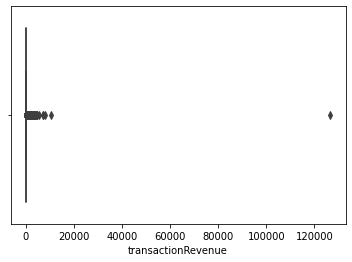

In [192]:
#letr's try to identify outliers
x=df.groupby(['fullVisitorID'])['transactionRevenue'].sum().sort_values(ascending=False)
sns.boxplot(x=x)

In [193]:
x.iloc[0:3]

fullVisitorID
1957458976293878100    126567.31
4471415710206918415     10465.10
9026840718082010040      7799.60
Name: transactionRevenue, dtype: float64

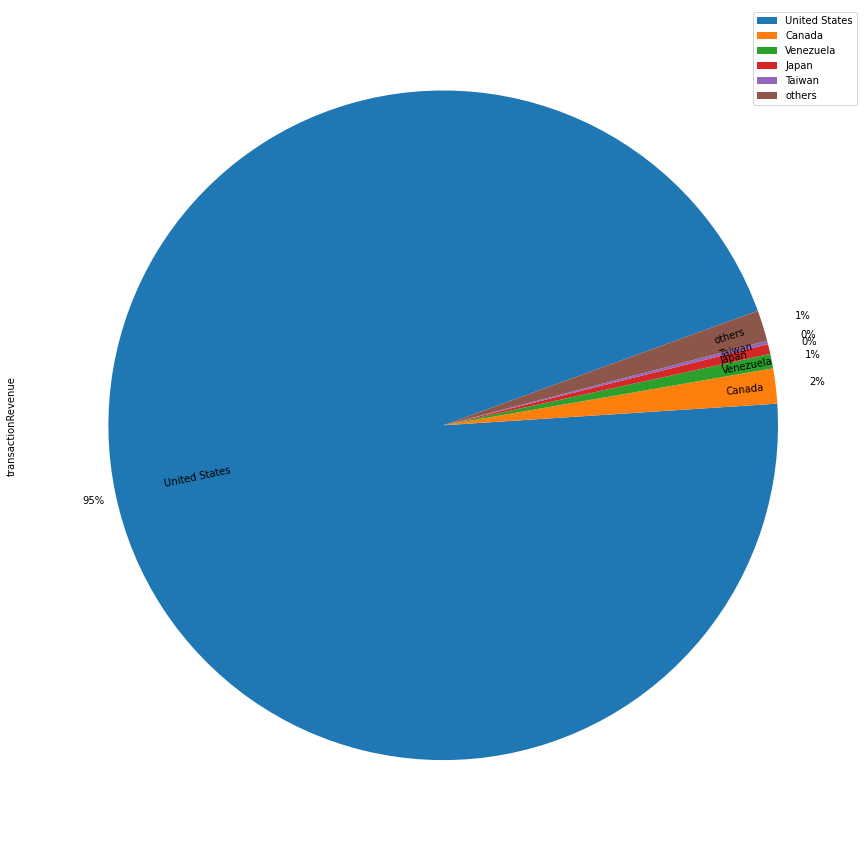

In [194]:
#Checking the countries with most Total Revenue

country_revenue = df.groupby(['country'])['country','transactionRevenue'].sum().reset_index()
country_revenue = pd.DataFrame(country_revenue)
country_revenue = country_revenue.loc[~((country_revenue['transactionRevenue'] == 0))]  
country_revenue = country_revenue.sort_values(by=['transactionRevenue'], ascending=False)

#the top 5

top_5 = country_revenue[:5].copy()

#others

new_row = pd.DataFrame(data = {
    'country' : ['others'],
    'transactionRevenue' : [country_revenue['transactionRevenue'][5:].sum()]})


#combining top 5 with others

country_revenue = pd.concat([top_5, new_row])

#plotting --

country_revenue.plot(kind = 'pie',
                     y = 'transactionRevenue',
                     labels = country_revenue['country'],
                     autopct='%1.0f%%',
                     pctdistance=1.1,
                     labeldistance=0.85,
                     rotatelabels =True,
                     textprops = dict(rotation_mode = 'anchor', va='center', ha='left'),
                     figsize=(15, 25),
                     startangle=20)
plt.xticks(rotation=20)
plt.show()

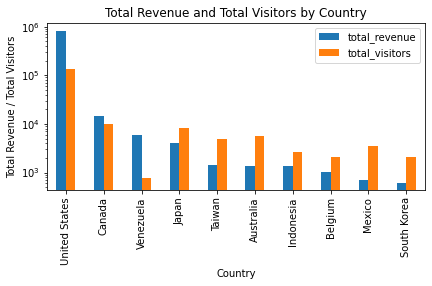

In [195]:
# group data by country and calculate total revenue and total number of visitors for each country

country_group = df.groupby('country').agg({'transactionRevenue': 'sum', 'fullVisitorID': 'nunique'})

country_group = country_group.rename(columns={'transactionRevenue': 'total_revenue', 'fullVisitorID': 'total_visitors'})

country_group = country_group.sort_values(by='total_revenue', ascending=False)

country_group = country_group.query('total_revenue != 0')

top_15 = country_group[:10].copy()

top_15.plot(kind='bar', y=['total_revenue', 'total_visitors'], stacked=False)


# set x-axis label
plt.xlabel('Country')

# set y-axis label
plt.ylabel('Total Revenue / Total Visitors')

# set title
plt.title('Total Revenue and Total Visitors by Country')

plt.semilogy()

plt.subplots_adjust(bottom=0.3,right=1)
# show plot
plt.show()

In [196]:
#changing the format date to manipulate it
df['date']= df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [197]:
#monthly revenue
monthly_rev = df.set_index('date').resample('M')["transactionRevenue"].sum().reset_index()
monthly_rev.head(7)

#monthly visitors
monthly_vis = df.set_index('date').resample('M')["fullVisitorID"].count().reset_index()

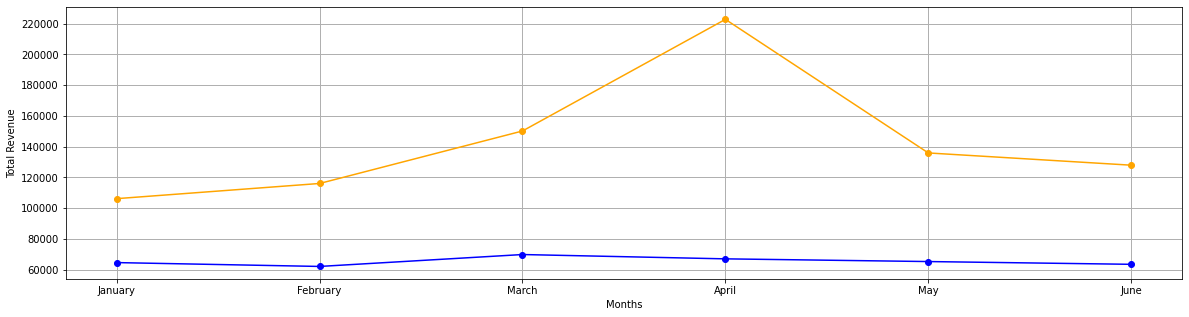

In [198]:
#plotting revenue per month, and visitors per month

months = ["January", "February", "March", "April", "May","June"]

plt.figure(figsize=(20,5))
plt.xlabel("Months")
plt.ylabel("Total Revenue")
plt.plot(months, monthly_rev.loc[:,'transactionRevenue'],"ro",linestyle="solid", color = "orange")
plt.plot(months, monthly_vis.loc[:,'fullVisitorID'],"ro",linestyle="solid", color = "blue")
plt.grid(linewidth = 1)

<AxesSubplot:ylabel='channelGrouping'>

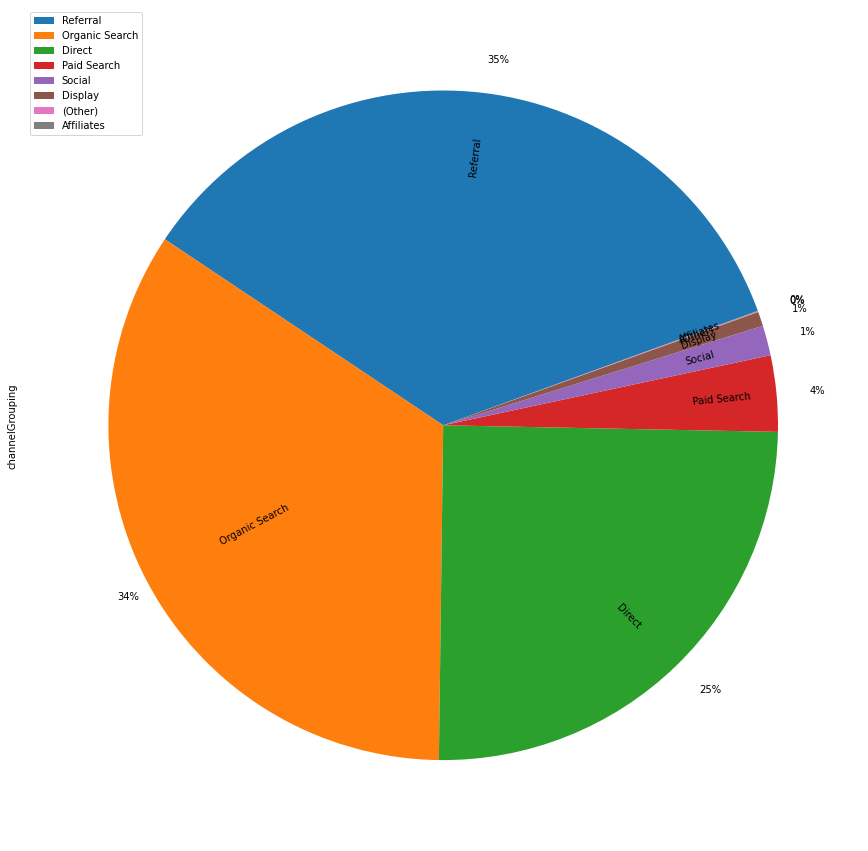

In [199]:
#the origin of the people that ended up converting. 

# identify users for which there is at least one transaction

keep = df['transactionRevenue'].ne(0).groupby(df['fullVisitorID']).any()

# keep those users

m1 = df['fullVisitorID'].isin(keep[keep].index)

# check where they came from for the first time

m2 = df['visitNumber'].eq(1)

# get the proportion of each source

grouping = df.loc[m1&m2, 'channelGrouping'].value_counts(normalize=True).reset_index()
grouping.plot(kind = 'pie',
              y = 'channelGrouping',
              labels = grouping['index'],
              autopct='%1.0f%%',
              pctdistance=1.1,
              labeldistance=0.75,
              rotatelabels =True,
              textprops = dict(rotation_mode = 'anchor', va='center', ha='left'),
              figsize=(15, 25),
              startangle=20)

<AxesSubplot:xlabel='visitNumber', ylabel='amount of transactions'>

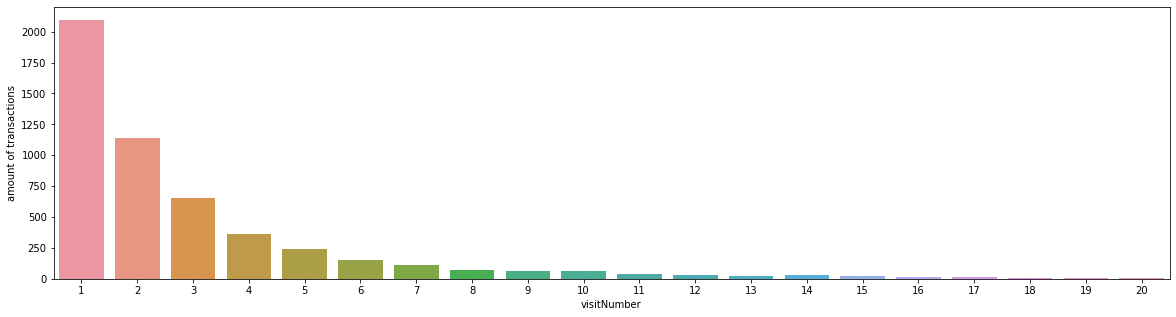

In [200]:
#Is there a relation between the visit Number and converting?

cond_1 = df['transactionRevenue'].ne(0)
m2 = df.loc[cond_1, ['visitNumber']].groupby(['visitNumber']).size().reset_index(name='amount of transactions')

#plotting

m2['visitNumber'] = m2['visitNumber'].astype(int)
m2 = m2.loc[m2['visitNumber'] <= 20]
plt.figure(figsize=(20,5))
sns.barplot(x=m2['visitNumber'], y=m2['amount of transactions'])

# **Machine learning model that predicts the probability that a user in a specific session will make a transaction.**

In [201]:
#I will drop the columns that I think won't really help to predict wether a costumer will convert or not.

df2 = df
df2 = df2.drop(['fullVisitorID','date','transactionRevenue'], axis=1)



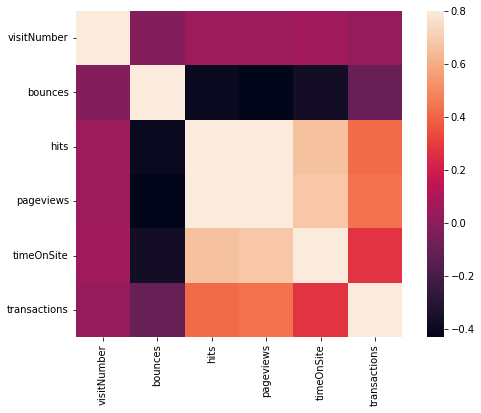

In [202]:
#Correlation matrix (heatmap style)

corrmat = df2.corr()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(corrmat, vmax=.8, square=True);

In [203]:
#If we see the page related data,
#we can conclude that they give almost the same information so multicollinearity really occurs, 

#So let's just keep one of those

df2 = df2.drop(['pageviews'], axis=1)

In [204]:
#we have to convert categorical variables to numbers. LabelEncoder does not seem to be the best solution
#to process these categorical variables since it puts an order and a hierarchy 
#between the categories that is not proper to the data.

#So I'm going to use Hot Encoding.


#But before using Hot encoding I want to group all the countries that did not make any transactions.

# group by country and sum transactions
grouped = df2.groupby('country')['transactions'].sum()
grouped.head()
how_many=0
# iterate through the groupby dataframe
for index, row in grouped.iteritems():
    # check if the sum of transactions is 0
    if row == 0:
        how_many+=1
        # replace the country name with "Others" in the original dataframe
        df2.loc[df['country'] == index, 'country'] = "Others"
        
print(how_many)


164


In [205]:
#There were 164 countries that haven't make any transactions ever. 

In [206]:
from sklearn.preprocessing import OneHotEncoder

# create a one-hot encoder
encoder = OneHotEncoder(sparse=False)

for i in ["country","channelGrouping","browser","deviceCategory","city","source"]:
    i_onehot = encoder.fit_transform(df2[[i]])
    i_df = pd.DataFrame(i_onehot, columns=encoder.get_feature_names([i]))
    i_df.head()
    df2 = df2.join(i_df)
    df2 = df2.drop([i], axis=1) #drop the column
    


In [207]:
df2.shape

(392892, 731)

In [208]:
#the transaction column will be my y, so it has to be binary, more than 1 transaction : True, else false.
df2['transactions']=df2['transactions'].apply(lambda x: 1 if x!=0 else 0)

In [209]:
#my X and y

X = df2.loc[:, df2.columns != 'transactions']
y = df2['transactions']

# **I've decided to use a standard forest algorithm to model my predictor.**

Random forest is an ideal algorithm to deal with the extreme imbalance owing to two main reasons. Firstly, the ability to incorporate class weights, Secondly, it combines the sampling technique and ensemble learning, therefore, downsampling the majority class and growing trees on a more balanced dataset.

In [210]:
#it's really important to take care of the imbalance of the data set: 
#SMOTE (Synthetic Minority Oversampling Technique) uses a minority class to generate synthetic samples.
#In consequence, it overcomes the overfitting problem raised by random oversampling.

oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y,
                                                                        test_size=0.1, stratify=over_y)

In [211]:
#Build SMOTE SRF model

SMOTE_SRF = RandomForestClassifier(n_estimators=225, random_state=0)

In [212]:
#Randomly spilt dataset to test and train set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [213]:
#Train SMOTE SRF

SMOTE_SRF.fit(over_X_train, over_y_train)

RandomForestClassifier(n_estimators=225, random_state=0)

In [214]:
#SMOTE SRF prediction result

y_pred = SMOTE_SRF.predict(X_test)

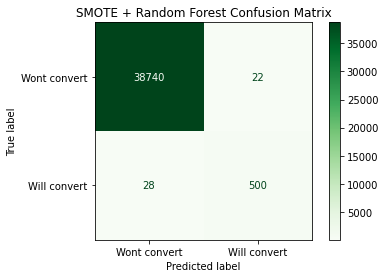

In [215]:
#Create confusion matrix

fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['Wont convert', 'Will convert'], cmap='Greens')
plt.title('SMOTE + Random Forest Confusion Matrix')
plt.show()

In [216]:
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy score:",accuracy)
precision = metrics.precision_score(y_test, y_pred)
print("Precision score:",precision)
recall = metrics.recall_score(y_test, y_pred) 
print("Recall score:",recall)

Accuracy score: 0.998727411555103
Precision score: 0.9578544061302682
Recall score: 0.946969696969697
